In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import datetime

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

## Load and clean data

In [3]:
meta = pd.read_excel("../DB Articoli V8.xlsx")
meta = meta.replace(np.nan, '', regex=True)

In [4]:
meta.head(1)

,ID,Titolo,Url,Data,Testo,Fonte,Trend 1
0,52360f85d1245da83f1da41ebc3e8449,Numenta Is Imitating Your Brain,https://singularityhub.com/2008/07/11/numenta-is-imitating-your-brain/,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,SingularityHub,


In [5]:
#meta.rename(columns={
#    'published': "Data",
#    'title': 'Titolo',
#    'summary': 'Testo'
#}, inplace=True)

In [6]:
meta['Data'] = pd.to_datetime(meta['Data'])

In [7]:
import hashlib

def generate_link_id(titolo):
    link_id = hashlib.md5(titolo.encode('utf-8')).hexdigest()
    return link_id

In [8]:
#articoli = meta[['ID','Titolo', 'Data', 'Testo']]
articoli = meta[['Titolo', 'Data', 'Testo']]
articoli['ID'] = articoli['Titolo'].apply(lambda x: generate_link_id(x))

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
articoli.head(1)

,Titolo,Data,Testo,ID
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449


In [10]:
print ("Numero totale di articoli: %d" % len(articoli['ID']))

Numero totale di articoli: 10703


## Insert Trends

In [ ]:
trend1 = []
for i in meta['Trend 1']:
    trend1.append(i)

Trend = []
for i in range(len(article_id)):
    l = []
    if len(trend1[i]): l.append(trend1[i])

    Trend.append(', '.join(map(str, list(l)))) 
    
Trend[0]## Remove stopwords from data

In [ ]:
# Create Tech Dataframe
trend = pd.DataFrame({'ID': article_id, 'Trend': Trend})
trend.head()

In [ ]:
articoli = pd.merge(articoli, trend, on = 'ID')

In [ ]:
# remove samples with no tags
articoli['Trend'] = articoli['Trend'].apply(lambda y: '' if len(y)==0 else y)
articoli = articoli[~(articoli['Trend'].str.len() == 0)]
articoli = articoli[~(articoli['Testo'].str.len() == 0)]
articoli = articoli.dropna(subset=['Data'])

In [ ]:
len(articoli)
print ("Numero totale di articoli: %d" % len(articoli))

## Clean Text

In [11]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    text = re.sub(r'[?|!|\'|"|#]',r'',text)
    text = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    text = text.replace("\n"," ")
    
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [12]:
articoli['Clean_Titolo'] = articoli['Titolo'].apply(lambda x: clean_text(x))
articoli['Clean_Testo'] = articoli['Testo'].apply(lambda x: clean_text(x))

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
print ("Numero totale di articoli: %d" % len(articoli))

Numero totale di articoli: 10703


In [14]:
articoli.head(1)
#articoli.sample(5, random_state=0)

,Titolo,Data,Testo,ID,Clean_Titolo,Clean_Testo
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta is imitating your brain,decent piece in businessweek profiling jeff hawkins startup numenta numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems the software specializes in recognizing patterns within massive streams of data i am a big fan of ...


## Remove stopwords from data

In [15]:
from nltk.corpus import stopwords

stop_words = nltk.corpus.stopwords.words('english')
my_stopwords = ['also','said', 'one', 'may', 'polls', 'sorry', 'like', 'use', 'many', 'make', 'could', 
                'even', 'says', 'new', 'us', 'would', 'time', 'companies', 'moment', 'way', 'using', 'two',
               'across', 'well', 'world', 'first', 'system', 'million', 'systems', 'including', 'example', 'year', 
                'based', 'googletagcmdpushfunction', 'th']
stop_words.extend(my_stopwords)

In [16]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [17]:
articoli['Clean_Titolo'] = articoli['Clean_Titolo'].apply(lambda x: remove_stopwords(x))
articoli['Clean_Testo'] = articoli['Clean_Testo'].apply(lambda x: remove_stopwords(x))

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
articoli['Txt'] = articoli['Clean_Titolo'] + " " + articoli['Clean_Testo']
del(articoli['Clean_Titolo'])
del(articoli['Clean_Testo'])

## Feature Engineering

In [19]:
def extract_date(df,column):
    df["Anno"] = df[column].apply(lambda x: x.year)
    df["Mese"] = df[column].apply(lambda x: x.month)
    df["Day"] = df[column].apply(lambda x: x.day)
    
extract_date(articoli, "Data")

In [20]:
def extract_week_number(df, column):
    df["Week"] = df[column].apply(lambda x: datetime.date(int(x.year), int(x.month), int(x.day)).strftime("%V"))
    #datetime.date(articoli['Data'][0].year, articoli['Data'][0].month , articoli['Data'][0].day).strftime("%V")
    
extract_week_number(articoli, "Data")

In [21]:
articoli.head(1)

,Titolo,Data,Testo,ID,Txt,Anno,Mese,Day,Week
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta imitating brain decent piece businessweek profiling jeff hawkins startup numenta numenta building artificial intelligence attempts replicate function human neocortex solve hard problems software specializes recognizing patterns within massive streams data big fan jeff hawkins short plug ...,2008,7,11,28


## Extract keywords for each row

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import re
## Remove stopwords from data
corpus = articoli['Txt']
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [23]:
#https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# get feature names
feature_names=cv.get_feature_names()

In [24]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [25]:
def extract_keys_for_row(doc, n):  
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    
    #extract only the top n
    keywords=extract_topn_from_vector(feature_names,sorted_items, n)
    
    kw = []
    for k in keywords:
        kw.append(k)

    kw2 = []
    for k in kw:
        if len(k.split()) == 2:
            kw2.append (k.split()[0].strip())
            kw2.append (k.split()[1].strip())
            
        if len(k.split()) == 3:
            kw2.append (k.split()[0].strip() + ' ' + k.split()[1].strip())
            kw2.append (k.split()[1].strip() + ' ' + k.split()[2].strip())
            kw2.append (k.split()[0].strip())
            kw2.append (k.split()[1].strip())
            kw2.append (k.split()[2].strip())
            
    kw = kw+kw2        
        
    return ", ".join(kw)
        
#extract_keys_for_row(articoli['Txt'][1], 25)

In [26]:
# TODO man mano che aumentano gli articoli sarà sempre più lungo: vanno estratti in un file separato
articoli['Keywords'] = articoli['Txt'].apply(lambda x: extract_keys_for_row(x,25))

In [27]:
articoli.head(1)

,Titolo,Data,Testo,ID,Txt,Anno,Mese,Day,Week,Keywords
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta imitating brain decent piece businessweek profiling jeff hawkins startup numenta numenta building artificial intelligence attempts replicate function human neocortex solve hard problems software specializes recognizing patterns within massive streams data big fan jeff hawkins short plug ...,2008,7,11,28,"jeff, brain, palm, decent, intelligence, specializes, tech industry, secrets, straightforward, inner, recognizing, introduction, pursue, replicate, fan, streams, unlock, neuroscience, dream, plug, attempts, book, degree, pilot, piece, tech, industry"


## Apply tags to keywords

provare a farlo anche sul testo

In [28]:
tags = pd.read_excel("Keywords to Tags V8.xlsx")
tags = tags.replace(np.nan, '', regex=True)
del(tags['Tag 1'])
del(tags['Tag 2'])
del(tags['Tag 3'])

In [29]:
tags = tags[~(tags['Tags'].str.len() == 0)]

In [30]:
tags.describe()

,Words,Tags
count,1238,1238
unique,1225,455
top,renewable energy,Tech: AI
freq,2,66


In [31]:
keywords = articoli[['ID','Keywords']]
keywords.head()

,ID,Keywords
0,52360f85d1245da83f1da41ebc3e8449,"jeff, brain, palm, decent, intelligence, specializes, tech industry, secrets, straightforward, inner, recognizing, introduction, pursue, replicate, fan, streams, unlock, neuroscience, dream, plug, attempts, book, degree, pilot, piece, tech, industry"
1,d99a761a52235562022f899b002022a5,"brain, synapses, conscious, reverse, engineer, machine, consciousness, strategies, decades, article, whose, koch, microscopy, simulating, foreseeable future, wiring, ieee, foreseeable, strengths, lesson, explicit, electron, titled, complementary, nervous, foreseeable, future"
2,f37e326486637f988d4864652e15c2f2,"singularity, ieee, report, special, www, highlighting, representing, selection, org, comprehensive, views, diverse, posts, located, spectrum, cool, fields, cover, interested, separate, produced, insights, read, issue, must"
3,2af2b2d721da8743585f9fd54f2d8aac,"stimulation, nerve, laser, nerves, cells, electrical, article, nearby, experiments, membrane, stimulating, caused, limbs, stimulate, desired, human, light, mechanism, tissue, damage, picture, contact, target, physical, hypothesis"
4,c131e5ae7fbeac377973ba06bea52999,"brain, healthy, member, singularity, try, login, screenshot, chart, specially, enough, per day, historical, abilities, index, participate, bodies, amazing, page, shape, get, excited, dedicated, signed, keeping, technological, per, day"


In [32]:
words = pd.concat([pd.Series(row['ID'], row['Keywords'].split(', ')) 
           for _, row in keywords.iterrows()]).reset_index().rename(columns={"index": "Words", 0: "ID"})
words.sort_values(by=['Words'], inplace=True)

In [33]:
#words.describe()
#words.to_csv('prova.csv', sep=";")

In [34]:
res = tags.merge(words, on="Words", how='left')

In [35]:
#res.head()
#res.to_csv('prova.csv', sep=";")

In [36]:
res = res.groupby('ID').agg(lambda x: x.tolist()).rename({'Tags': 'ComputedTags'}, axis=1)

In [37]:
res.head(1)

,Words,ComputedTags
ID,,
0000e2070c13ff3dd2b8b8c0f4225f17,"[air, air, air quality, cleantech, climate, facebook, facebook, facebook, facebook, facebook, twitter, twitter, twitter]","[Tag: Air, Tag: Air, Tag: Air, Tag: Pollution, Tag: Clean Technology, Tag: Climate Change, Company: Facebook, Vertical: Technology, Company: Facebook, Vertical: Technology, Company: Facebook, Vertical: Technology, Company: Facebook, Vertical: Technology, Company: Facebook, Vertical: Technology, ..."


In [38]:
def list_to_csv(text):
    str_list = ", " . join(text)

    str_list = str_list.split(", ")
    str_list = list(map(str.strip, str_list))
    str_list = list(filter(None, str_list))
    str_list = list(set(str_list))
    str_list = ", " . join(str_list)
    
    return str_list
    
list_to_csv(res['ComputedTags'][1])

'Location: United States of America, Tag: Climate Change, Vertical: Energy & Utility, Tag: Carbon Emissions, People: Donald Trump, Application: Economy'

In [39]:
res['ComputedTags'] = res['ComputedTags'].apply(lambda x: list_to_csv(x))

In [40]:
res.head()

,Words,ComputedTags
ID,,
0000e2070c13ff3dd2b8b8c0f4225f17,"[air, air, air quality, cleantech, climate, facebook, facebook, facebook, facebook, facebook, twitter, twitter, twitter]","Tag: Climate Change, Company: Twitter, Tag: Clean Technology, Tag: Pollution, Company: Facebook, Vertical: Technology, Tag: Air"
0007da42ffe927b4c1342461a66f9a2d,"[climate, climate, climate change, economy, emissions, oil, trump, trump]","Location: United States of America, Tag: Climate Change, Vertical: Energy & Utility, Tag: Carbon Emissions, People: Donald Trump, Application: Economy"
0009e42a6f21891a171b30d1b415d5f4,"[economic, economic, legal, meeting, start ups, switzerland, switzerland, uber]","Application: Legal, Company: Uber, Vertical: Automotive, Tag: Meetings, Application: Economy, Location: Switzerland, Tag: Startup"
000ba56372d999c4b16ec1bd2bb13a9b,"[ad, twitter]","Vertical: Technology, Company: Twitter, Vertical: Advertising"
0021a5c5b7e75c70e0ad0a0d1193a873,"[ai, apps, car, car, data, ford, learning, mercedes, mercedes, nvidia, platform, safety, self driving, vehicle, vehicles]","Tag: Platform, Company: Mercedes, Vertical: Automotive, Tag: Safety, Tech: AI, Application: Autonomous Vehicles, Company: NVIDIA, Tag: Development, Tech: Mobile, Company: Ford, Vertical: Technology, Tag: Data"


In [41]:
articoli = articoli.merge(res, on="ID", how='left')
articoli = articoli.replace(np.nan, '', regex=True)

In [42]:
articoli.head(2)

,Titolo,Data,Testo,ID,Txt,Anno,Mese,Day,Week,Keywords,Words,ComputedTags
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta imitating brain decent piece businessweek profiling jeff hawkins startup numenta numenta building artificial intelligence attempts replicate function human neocortex solve hard problems software specializes recognizing patterns within massive streams data big fan jeff hawkins short plug ...,2008,7,11,28,"jeff, brain, palm, decent, intelligence, specializes, tech industry, secrets, straightforward, inner, recognizing, introduction, pursue, replicate, fan, streams, unlock, neuroscience, dream, plug, attempts, book, degree, pilot, piece, tech, industry","[brain, neuroscience, tech, tech industry]","Tag: Neuroscience, Tech: Brain Computer Interfaces, Vertical: Health & Medicine, Tag: Technology"
1,Want to reverse engineer the brain? Reverse engineer the roundworm first…,2008-07-16,From the IEEE report on the singularity I found an interesting piece of information from the article titled Can Can Machines Be Conscious? by Christof Koch and Giulio Tononi. It would seem mankind s attempt to reverse engineer the brain is quite a ways off if we can t even reverse engineer the 3...,d99a761a52235562022f899b002022a5,want reverse engineer brain reverse engineer roundworm ieee report singularity found interesting piece information article titled machines conscious christof koch giulio tononi seem mankind attempt reverse engineer brain quite ways reverse engineer neuron roundworm article best build conscious m...,2008,7,16,29,"brain, synapses, conscious, reverse, engineer, machine, consciousness, strategies, decades, article, whose, koch, microscopy, simulating, foreseeable future, wiring, ieee, foreseeable, strengths, lesson, explicit, electron, titled, complementary, nervous, foreseeable, future","[brain, consciousness, future, ieee, simulating]","Tech: Brain Computer Interfaces, Tag: Neuroscience, Tag: Future, Tag: Simulation, Vertical: Technology, Company: IEEE"


In [43]:
def count_tags(tags):
    tag_list = tags.split(",")
    
    #deduplica
    tag_list = list(map(str.strip, tag_list))
    tag_list = list(filter(None, tag_list))
    tag_list = list(set(tag_list))
    
    return (len(tag_list))
    
count_tags(articoli['ComputedTags'][0])

4

In [44]:
articoli['NumberOfTags'] = articoli['ComputedTags'].apply(lambda x: count_tags(x))

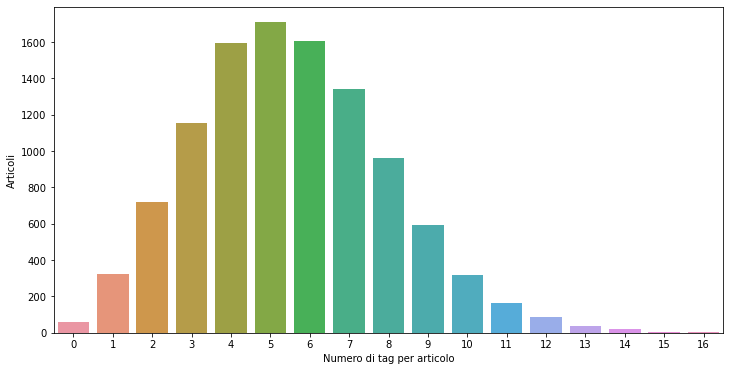

In [45]:
plt.figure(figsize=(12,6))
ax=sns.countplot(articoli["NumberOfTags"])
plt.xlabel("Numero di tag per articolo")
plt.ylabel("Articoli")
plt.show()

In [46]:
df_zero = articoli[articoli['NumberOfTags'] == 0]
print ("articoli senza tags: %d" % len(df_zero['ID']))

articoli senza tags: 59


In [47]:
df_uno = articoli[articoli['NumberOfTags'] == 1]
print ("articoli con un solo tag: %d" % len(df_uno['ID']))

articoli con un solo tag: 326


In [48]:
#df_zero.to_csv('prova.csv', sep=";")

## Split tags in columns

In [49]:
## Extract keywords for each row
def get_tags_types(tags):
    tag_types = []
    for tag in tags:
        t1 = tag.split(",")[0]
        if len(t1):
            t2 = t1.split(":")[0]
            tag_types.append(t2)
            
    tag_types = list(map(str.strip, tag_types))
    tag_types = list(filter(None, tag_types))
    tag_types = list(set(tag_types))
    
    return tag_types
    
get_tags_types(articoli['ComputedTags'])

['Company', 'People', 'Tech', 'Vertical', 'Tag', 'Location', 'Application']

In [50]:
def split_tags_in_columns(tags, column):
    tag_list = tags.split(",")

    tag = []
    for t in tag_list:
        if t.split(":")[0].strip() == column:
            tag.append(t.split(":")[1].strip())
            #return t.split(":")[1].strip()
        
    str_tag = ", " . join(tag)
    return str_tag
    
split_tags_in_columns(articoli['ComputedTags'][4], 'Tech')

'Brain Computer Interfaces'

In [51]:
for tt in get_tags_types(articoli['ComputedTags']):
    articoli[tt] = articoli['ComputedTags'].apply(lambda x: split_tags_in_columns(x, tt))

## Save assets

In [52]:
import pickle
#with open('stop_words', 'wb') as stopwords_dump:
#    pickle.dump(stop_words, stopwords_dump)

In [53]:
output_filename = 'temp/db'
articoli.to_csv(output_filename, sep=";")

# Simbiosity

In [ ]:
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

df = articoli[['Data', 'Tech']]
df = df[~(df['Tech'].str.len() == 0)]
#df['Data'] = pd.to_datetime(df['Data']).dt.date

### Apply Simbiosity Taxonomy

In [ ]:
df.count()

In [ ]:
def expand_column(tags, colname):
    if colname in tags:
        return 1

    return 0

expand_column(articoli['Tech'][23], 'Artificial Intelligence')

In [ ]:
col_list = [
    'Artificial Intelligence', 'Deep Learning', 'Machine Learning', 'Math and Statistics', 'RPA', 'Reinforced Learning',
    'Virtual Reality', 'Augmented Reality', 'Haptics', 'Brain Computer Interfaces',
    'IoT', 'Robotics', 'Sensors', 'Drones', 'Lidar'
]

In [ ]:
for c in col_list:
    df[c] = df['Tech'].apply(lambda x: expand_column(x, c))

In [ ]:
df['AI'] = (df['Artificial Intelligence'] + df['Deep Learning'] 
             + df['Machine Learning'] + df['Reinforced Learning']
             + df['Math and Statistics'] + df['RPA'])

df['XR'] = (df['Virtual Reality'] + df['Augmented Reality'] + df['Haptics'] 
             + df['Brain Computer Interfaces'])

df['IIoT'] = (df['IoT'] +df['Robotics'] + df['Sensors'] + df['Drones'] + df['Lidar'])

df.drop(['Artificial Intelligence', 'Deep Learning', 'Machine Learning', 'Math and Statistics', 'RPA', 'Reinforced Learning',
    'Virtual Reality', 'Augmented Reality', 'Haptics', 'Brain Computer Interfaces',
    'IoT', 'Robotics', 'Sensors', 'Drones', 'Lidar'], axis=1, inplace=True)

In [ ]:
#serve pure qui la explode
df.count()

In [ ]:
df = df.set_index(df['Data'])
#df = df.resample('M').sum()

In [ ]:
df["Somma"] = df[list(df)].sum(axis=1)

In [ ]:
df['AI%'] = df['AI'] / df['Somma']
df['XR%'] = df['XR'] / df['Somma']
df['IIoT%'] = df['IIoT'] / df['Somma']
df = df.replace(np.nan, 0, regex=True)

In [ ]:
df_monthly = df.resample('M').sum()
df_yearly = df.resample('M').sum()

In [ ]:
start = '2019-01-01'
#start = '2020-02-01'
end = '2020-08-31'

### Mounthly % of articles about AI overall (2020)

In [ ]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

# Horizontal Bar Plot 
#df_monthly.loc['2019':'2020-08-31', 'AI%'].plot.barh()
df_monthly.loc[start:end, 'AI%'].plot.barh()

ax.set_yticklabels(df_monthly.loc[start:end, 'AI%'].index.strftime('%B %Y'))
  
# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove x axis value
ax.xaxis.set_visible(False)
  
# Show top values  
# ax.invert_yaxis() 
  
# Add annotation to bars 
#for i in ax.patches:
#    if i.get_width() > 0:
#        plt.text(i.get_width()+0.01, i.get_y()+0.2, "{:.2%}".format(round(i.get_width(),3)), 
#                 fontsize = 10, fontweight ='bold', color ='grey') 

# Add Plot Title 
ax.set_title('Monthly % of articles about AI overall (2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)### % of AI Articles overall
  
# Show Plot 
plt.show() 

### Yearly articles about selected technologies (2014 - 2020)

In [ ]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df_yearly.index
y1 = df_yearly['AI']
y2 = df_yearly['XR']
y3 = df_yearly['IIoT']

plt.plot(x,y1,marker='.', label="Artificial Intelligence")
plt.plot(x,y2,marker='.', label='Extended Reality')
plt.plot(x,y3,marker='.', label='Industrial IoT')

# Add Plot Title 
ax.set_title('Yearly articles about selected technologies (2014 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

#plt.legend()

# Show Plot 
plt.show() 

In [ ]:
df_x = df_monthly.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

df_x['AI'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['XR'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['IIoT'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
    
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove y axis value
ax.yaxis.set_visible(False)

#plt.legend()

# Add Plot Title 
ax.set_title('Mounthly articles about selected technologies (2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

# Show Plot 
plt.show() 

### Tech + Application

In [ ]:
tech_appl = articoli[['Data', 'Tech', 'Application']]
tech_appl = tech_appl[~(tech_appl['Tech'].str.len() == 0)]
tech_appl = tech_appl[~(tech_appl['Application'].str.len() == 0)]
tech_appl = tech_appl.set_index(tech_appl['Data'])

In [ ]:
tech_appl.head()

In [ ]:
def explode(df):
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])

    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

    res = pd.merge(df1,df2,on='Data',how='left')
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [ ]:
tech_appl = explode(tech_appl)

In [ ]:
tech_appl

### Top Applications

In [ ]:
count_series = tech_appl.groupby(['Application']).size()
applications = count_series.to_frame(name = 'Size').reset_index()
applications = applications[applications.Size > 100]
applications.sort_values(by = 'Size', ascending=False, inplace=True)
applications.head()

In [ ]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=applications)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")


# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
ax.yaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Top applications', loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### Tech = Artificial Intelligence

In [ ]:
df_AI = tech_appl.loc[tech_appl['Tech'] == "Artificial Intelligence"]
count_series = df_AI.groupby(['Tech', 'Application']).size()

df_AI = count_series.to_frame(name = 'Size').reset_index()
df_AI = df_AI[df_AI.Size > 40]
df_AI.sort_values(by = 'Size', ascending=False, inplace=True)
df_AI.head()

In [ ]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=df_AI)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Top Applications for Artificial Intelligence', loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### Application = Autonomous Vehicles

In [ ]:
df_AutonomousVehicles = tech_appl.loc[tech_appl['Application'] == "Autonomous Vehicles"]
count_series = df_AutonomousVehicles.groupby(['Tech', 'Application']).size()

df_AutonomousVehicles = count_series.to_frame(name = 'Size').reset_index()
df_AutonomousVehicles = df_AutonomousVehicles[df_AutonomousVehicles.Size < 100]
df_AutonomousVehicles = df_AutonomousVehicles[df_AutonomousVehicles.Size > 10]
df_AutonomousVehicles.sort_values(by = 'Size', ascending=False, inplace=True)
df_AutonomousVehicles.head()

In [ ]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Tech', y='Size', data=df_AutonomousVehicles)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Technologies for Autonomous Vehicles applications', loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### Application = Energy Storage

In [ ]:
df_energystorage = tech_appl.loc[tech_appl['Application'] == "Energy Storage"]
count_series = df_energystorage.groupby(['Tech', 'Application']).size()

df_energystorage = count_series.to_frame(name = 'Size').reset_index()
df_energystorage = df_energystorage[df_energystorage.Size > 10]
df_energystorage.sort_values(by = 'Size', ascending=False, inplace=True)
df_energystorage.head()

In [ ]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Tech', y='Size', data=df_energystorage)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.ylabel("Articoli")
plt.xlabel("Tecnologia")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
ax.yaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Technologies for Energy Storage applications', loc ='left') 

# Add Text watermark 
ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

In [ ]:
df = articoli[['Data', 'Tech', 'Application']]
df = df[~(df['Tech'].str.len() == 0)]
df = df[~(df['Application'].str.len() == 0)]

In [ ]:
df

In [ ]:
def explode(df):
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])

    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

    res = pd.merge(df1,df2,on='Data',how='left')
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [ ]:
df = explode(df)

In [ ]:
df

In [ ]:
df['Application'].unique()

In [ ]:
for c in df['Application'].unique():
    df[c] = df['Application'].apply(lambda x: expand_column(x, c))

In [ ]:
#df

In [ ]:
df = df.set_index(df['Data'])
df = df.resample('M').sum()

In [ ]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df.loc[start:end].index
y1 = df.loc[start:end, 'Energy Storage']
y2 = df.loc[start:end, 'Power Generation']
y3 = df.loc[start:end, 'Water Processing']
y4 = df.loc[start:end, 'Recharge Infrastructure']

plt.plot(x,y1,marker='.', label="Energy Storage")
plt.plot(x,y2,marker='.', label='Power Generation')
plt.plot(x,y3,marker='.', label='Water Processing')
plt.plot(x,y4,marker='.', label='Recharge Infrastructure')

# Add Plot Title 
ax.set_title('Yearly articles about energy related applications (2014 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.legend()

# Show Plot 
plt.show() 